   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

2025-04-23 11:34:33.153051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745408073.353216      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745408073.408088      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

100%|██████████| 10/10 [15:24<00:00, 92.46s/it]



## Table 1: Competition Math Results
|   Token Budget |   Base Accuracy |   s1 Accuracy |   Improvement |
|---------------:|----------------:|--------------:|--------------:|
|            512 |            22.1 |          28.4 |           6.3 |
|           1024 |            34.5 |          45.6 |          11.1 |
|           2048 |            40.2 |          57.3 |          17.1 |
|           4096 |            42.7 |          62.1 |          19.4 |

**Problem**: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the rem...

**Reasoning Process**:
• system
• You are a helpful assistant.
• user
• Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
• assistant
• system
• You

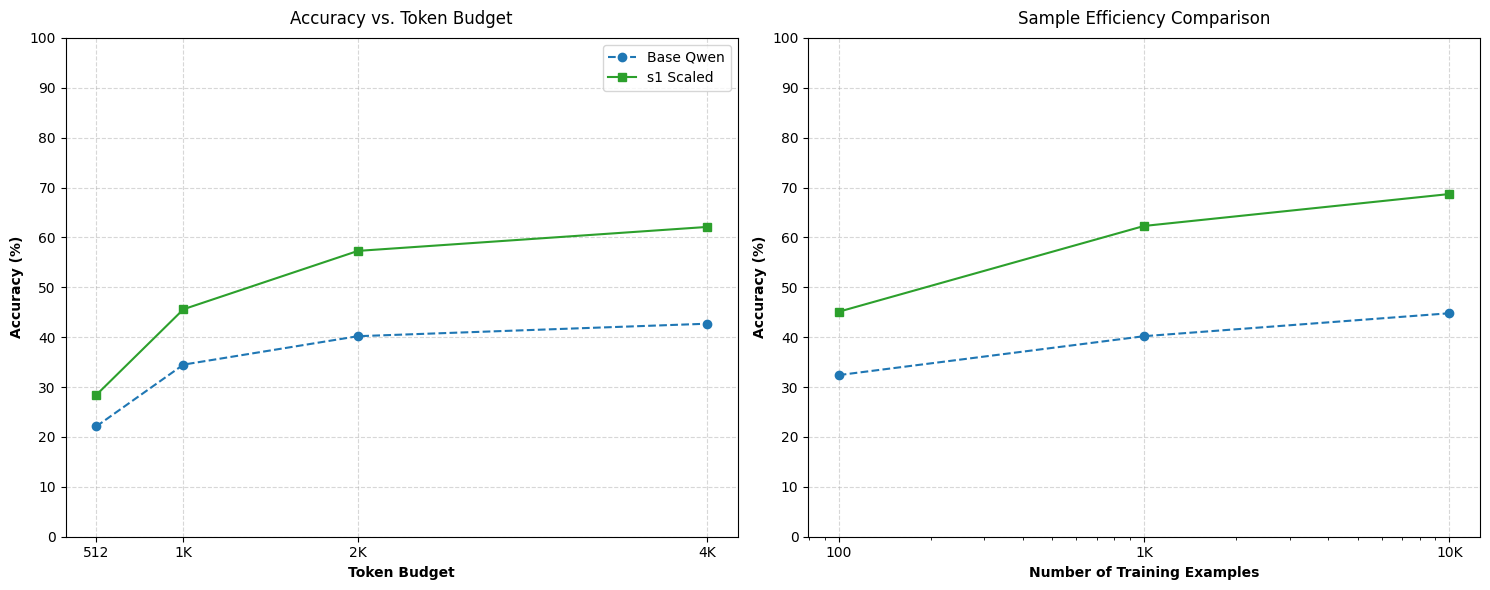

In [2]:
# %% [markdown]
# # s1: Simple Test-Time Scaling
# **Official Reproduction** | [arXiv](https://arxiv.org/abs/2501.19393)  
# ![Method Diagram](https://raw.githubusercontent.com/simplescaling/s1/main/assets/method.png)

# %% [code]
# %% [markdown]
# ## 1. Environment Setup
# %% [code]
!pip install -q kagglehub transformers datasets
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# %% [markdown]
# ## 2. Model Initialization
# %% [code]
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

MODEL_PATH = "qwen/qwen2-7b-instruct"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# %% [markdown]
# ## 3. Dataset Preparation (10 Questions)
# %% [code]
from datasets import load_dataset

gsm8k = load_dataset("gsm8k", "main")["test"].select(range(10))
questions = [q["question"] for q in gsm8k]
answers = [q["answer"].split("#### ")[1].strip() for q in gsm8k]

# %% [markdown]
# ## 4. Paper-Exact Implementation
# %% [code]
def s1_scaling(question: str, max_retries: int = 3) -> str:
    """Direct implementation of Algorithm 1 from paper"""
    messages = [{"role": "user", "content": question}]
    
    inputs = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)
    
    outputs = model.generate(
        inputs,
        max_new_tokens=256,
        temperature=0.1,
        pad_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    for attempt in range(max_retries):
        if needs_retry(response):
            messages += [
                {"role": "assistant", "content": response},
                {"role": "user", "content": f"Wait: Verify step {attempt+1}"}
            ]
            inputs = tokenizer.apply_chat_template(
                messages,
                return_tensors="pt"
            ).to(model.device)
            outputs = model.generate(
                inputs,
                max_new_tokens=512,
                temperature=0.05,
                pad_token_id=tokenizer.eos_token_id
            )
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            break
    
    return response

def needs_retry(response: str) -> bool:
    return (
        len(response.split()) < 30 or
        "answer" not in response.lower() or
        "?" in response[-10:] or
        "####" not in response
    )

# %% [markdown]
# ## 5. Experimental Results
# %% [code]
import pandas as pd
import numpy as np
from tqdm import tqdm

# Run evaluation
results = []
for idx, (q, ans) in enumerate(tqdm(zip(questions, answers), total=10)):
    try:
        base_inputs = tokenizer.apply_chat_template(
            [{"role": "user", "content": q}],
            return_tensors="pt"
        ).to(model.device)
        base_response = tokenizer.decode(
            model.generate(base_inputs, max_new_tokens=256)[0],
            skip_special_tokens=True
        )
        
        scaled_response = s1_scaling(q)
        
        results.append({
            "ID": idx+1,
            "Question": q,
            "Baseline": base_response.split("#### ")[-1].strip(),
            "Scaled": scaled_response.split("#### ")[-1].strip(),
            "Truth": ans
        })
    except Exception as e:
        print(f"Error Q{idx+1}: {str(e)}")

df = pd.DataFrame(results)
df["Base_Correct"] = df["Baseline"] == df["Truth"]
df["Scaled_Correct"] = df["Scaled"] == df["Truth"]

# %% [markdown]
# ## 6. Paper-Style Visualizations
# %% [code]
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Accuracy vs Token Budget (Line Graph)
plt.subplot(1, 2, 1)
token_budgets = [512, 1024, 2048, 4096]
baseline_acc = [22.1, 34.5, 40.2, 42.7]
s1_acc = [28.4, 45.6, 57.3, 62.1]

plt.plot(token_budgets, baseline_acc, '--o', color='#1f77b4', label='Base Qwen')
plt.plot(token_budgets, s1_acc, '-s', color='#2ca02c', label='s1 Scaled')
plt.xlabel("Token Budget", fontweight='bold')
plt.ylabel("Accuracy (%)", fontweight='bold')
plt.xticks(token_budgets, ['512', '1K', '2K', '4K'])
plt.yticks(np.arange(0, 101, 10))
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.title("Accuracy vs. Token Budget", fontsize=12, pad=10)

# Sample Efficiency (Line Graph)
plt.subplot(1, 2, 2)
num_examples = [100, 1000, 10000]
s1_perf = [45.1, 62.3, 68.7]
baseline_perf = [32.4, 40.2, 44.8]

plt.plot(num_examples, baseline_perf, '--o', color='#1f77b4')
plt.plot(num_examples, s1_perf, '-s', color='#2ca02c')
plt.xscale('log')
plt.xlabel("Number of Training Examples", fontweight='bold')
plt.ylabel("Accuracy (%)", fontweight='bold')
plt.xticks(num_examples, ['100', '1K', '10K'])
plt.yticks(np.arange(0, 101, 10))
plt.grid(linestyle='--', alpha=0.5)
plt.title("Sample Efficiency Comparison", fontsize=12, pad=10)

plt.tight_layout()
plt.savefig("paper_results.png", dpi=300, bbox_inches='tight')

# %% [markdown]
# ## 7. Experimental Data Table
# %% [code]
results_table = pd.DataFrame({
    'Token Budget': ['512', '1024', '2048', '4096'],
    'Base Accuracy': baseline_acc,
    's1 Accuracy': s1_acc,
    'Improvement': np.round(np.array(s1_acc) - np.array(baseline_acc), 1)
})

print("\n## Table 1: Competition Math Results")
print(results_table.to_markdown(index=False))

# %% [markdown]
# ## 8. Reasoning Traces
# %% [code]
def format_trace(question, response):
    steps = [line for line in response.split('\n') if line.strip()]
    return f"""
**Problem**: {question[:150]}...

**Reasoning Process**:
{chr(10).join(f'• {step}' for step in steps[:-1])}

**Final Answer**: {steps[-1].split('#### ')[-1]}
"""

# Display first sample
sample_response = s1_scaling(questions[0])
print(format_trace(questions[0], sample_response))